Suggestions for imporving dataset features:
1. Increase diversity of features: expand industry categories, introduce new metrics (project completion rate, number of patents, revenue, geographical presence etc.)
2. Refine strength categories: specific criteria for each strenght level to reduce subjectivity
3. Feature engineering: interaction features that capture interactions between different fields (e.g combined expertise in ML and NLP)
4. Dimensionality reduction: PCA or UMAP

Dataset can incorporate internal company features as follows:
1. Instead of Publication Rate, Industry Orientation etc. modify features in the form "Need for publications/industry collaborations/ members etc. so that interpretation of strengths and weaknesses is uniform.

In [376]:
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score, make_scorer, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA


In [126]:
!pip install umap

  Preparing metadata (setup.py) ... done
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3541 sha256=136cc31649c6bdf80ee7fb98c78234f44d4f89e06442d157c50cf793240b7f5d
  Stored in directory: /Users/kimonanagnostopoulos/Library/Caches/pip/wheels/48/4a/1c/1d511cbb0413a448d8546e958f8e82b98d9bb493038d19ece2
Successfully built umap


In [403]:
!pip install kneed
from kneed import KneeLocator

In [329]:
involvement_columns = ['Security', 'Humanities', 'Nat. Sci', 'Health', 'AI Ethics', 'Big Data', 
                           'Robotics', 'Documents', 'Multimedia', 'NLP', 'KRR', 'Graphs', 'DL/ML', 
                           'Funding', 'Application-Oriented', 'Number of Members', 
                           'Academic Collaborations', 'System Maturity', 'Demos', 'Industrial Collaborations']

In [83]:
industry_cols = ['Security', 'Humanities', 'Nat. Sci', 'Health', 'AI Ethics', 'Big Data', 'Robotics', 'Documents', 'Multimedia', 'NLP', 'KRR', 'Graphs', 'DL/ML']

In [84]:
comp_cols = ['Number of Members', 'Application-Oriented', 'Academic Collaborations', 
                      'System Maturity', 'Demos', 'Industrial Collaborations']

In [85]:
feature_weights = {
    'Security': 1.0, 'Humanities': 1.0, 'Nat. Sci': 1.0, 'Health': 1.0, 'AI Ethics': 1.0, 'Big Data': 1.0, 'Robotics': 1.0, 
    'Documents': 1.0, 'Multimedia': 1.0, 'NLP': 1.0, 'KRR': 1.0, 'Graphs': 1.0, 'DL/ML': 1.0, 
    'Number of Members': 0.5, 'Application-Oriented': 0.5, 'Academic Collaborations': 0.5, 'System Maturity': 0.5, 
    'Demos': 0.5, 'Industrial Collaborations': 0.5
}

In [86]:
weights = {'Strong': 3, 'Good': 2, 'Average': 1, 'None': 0}

In [215]:
def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path, index_col=0).transpose()
    for column in involvement_columns:
        if column in data.columns:
            data[column] = data[column].map(weights).fillna(0)
    return data

In [88]:
def assign_weights(data):
    for column, weight in feature_weights.items():
        if column in data.columns:
            data[column] = data[column]*weight

In [216]:
def standardize_data(data):
    scaler = StandardScaler()
    return pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)

In [136]:
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

Hyperparameter Optimization
-Adjusting encoding dimension
-Learning Rate and Epochs
-Additional Layers

In [235]:
def create_autoencoder(input_dim, encoding_dim, layer_sizes, dropout_rate=0.2):
    input_layer = Input(shape=(input_dim,), name='input_layer')
    x = input_layer
    
    # Add encoder layers
    for size in layer_sizes:
        x = Dense(size)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Dropout(dropout_rate)(x)
    
    encoded = Dense(encoding_dim, activation='relu', name='encoded_layer')(x)
    
    # Add decoder layers (reverse of encoder)
    for size in reversed(layer_sizes):
        x = Dense(size)(encoded)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Dropout(dropout_rate)(x)
    
    decoded = Dense(input_dim, activation='sigmoid')(x)
    
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer=Adam(), loss='mean_squared_error')
    
    return autoencoder


In [313]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def train_autoencoder(autoencoder, train_data, val_data, epochs=50, batch_size=32):
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
    
    history = autoencoder.fit(train_data, train_data,
                              validation_data=(val_data, val_data),
                              epochs=epochs, batch_size=batch_size, shuffle=True, verbose=2,
                              callbacks=[early_stopping, reduce_lr])
    
    return history.history['loss'], history.history['val_loss']



In [220]:
def get_encoded_data(autoencoder, data):
    encoder_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoded_layer').output)
    return encoder_model.predict(data)


In [221]:
def apply_agglomerative_clustering(data, n_clusters):
    clustering = AgglomerativeClustering(n_clusters=n_clusters)
    return clustering.fit_predict(data)

In [402]:
def apply_kmeans_clustering(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
    kmeans.fit(data)
    return kmeans.labels_

In [223]:
def apply_dbscan_clustering(data, eps, min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    return dbscan.fit_predict(data)

In [224]:
def evaluate_clustering(data, labels):
    silhouette_avg = silhouette_score(data, labels)
    davies_bouldin = davies_bouldin_score(data, labels)
    return silhouette_avg, davies_bouldin

In [451]:
def find_optimal_clusters(data, clustering_func, cluster_range):
    silhouette_scores = []
    davies_bouldin_scores = []
    inertia_scores = []

    for n_clusters in cluster_range:
        labels = clustering_func(data, n_clusters)
        silhouette_avg = silhouette_score(data, labels)
        davies_bouldin_avg = davies_bouldin_score(data, labels)
        
        # Assuming KMeans for inertia
        kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(data)
        inertia_scores.append(kmeans.inertia_)
        
        silhouette_scores.append(silhouette_avg)
        davies_bouldin_scores.append(davies_bouldin_avg)
    
    # Debug prints to understand the scores
    print(f'Silhouette Scores: {silhouette_scores}')
    print(f'Davies-Bouldin Scores: {davies_bouldin_scores}')
    print(f'Inertia Scores: {inertia_scores}')
    
    # Use KneeLocator to find the elbow point in inertia scores
    try:
        kneedle = KneeLocator(cluster_range, inertia_scores, curve='convex', direction='decreasing')
        elbow_point = kneedle.elbow
        if elbow_point is None:
            raise ValueError('Elbow point not found.')
    except ValueError as e:
        print(f'Error finding elbow point: {e}')
        # Fallback: use the number of clusters with the best silhouette score
        elbow_point = cluster_range[np.argmax(silhouette_scores)]
        print(f'Fallback to the best silhouette score: {elbow_point}')
    
    optimal_clusters = elbow_point
    print(f'Optimal number of clusters determined: {optimal_clusters}')
    return optimal_clusters


In [405]:
def visualize_clusters(data, labels, method='pca'):
    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        from sklearn.manifold import TSNE
        reducer = TSNE(n_components=2, random_state=42)
    else:
        raise ValueError("Method not recognized: choose 'pca', or 'tsne'")
        
    reduced_data = reducer.fit_transform(data)
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis')
    plt.title(f'Clusters visualization using {method.upper()}')
    plt.show()

In [304]:
# Main execution
filepath = 'data/synthetic_data.csv'
# Load and preprocess data
dfs = load_and_preprocess_data(filepath)

In [289]:
assign_weights(dfs)
df_scaled = standardize_data(dfs)
input_dim = df_scaled.shape[1]

In [230]:
df_scaled

Field,Security,Humanities,Nat. Sci,Health,AI Ethics,Big Data,Robotics,Documents,Multimedia,NLP,KRR,Graphs,DL/ML,Funding,Application-Oriented,Number of Members,Academic Collaborations,System Maturity,Demos,Industrial Collaborations
"Hall, Nelson and Parks",-0.448676,1.977899,-0.470697,-0.688054,-0.706794,-0.224874,-0.302825,2.124205,-0.539798,-0.723123,-1.325477,-0.586008,0.444830,0.458095,-0.251883,1.343749,1.155235,1.042366,1.202662,-0.154439
Krueger LLC,0.790760,-0.905336,2.940148,-0.688054,-0.706794,-1.079909,3.302236,-0.526633,-0.539798,-0.723123,0.766831,-0.586008,-0.566148,-1.207704,0.848042,0.084378,1.155235,-0.171098,0.029333,-0.154439
Lewis Ltd,-0.448676,-0.905336,-0.470697,-0.688054,-0.706794,-0.224874,-0.302825,-0.526633,-0.539798,1.799400,0.766831,-0.586008,-0.566148,-1.207704,-0.251883,1.343749,1.155235,1.042366,1.202662,1.918574
Simpson Group,-0.448676,-0.905336,2.940148,-0.688054,-0.706794,1.485195,-0.302825,1.240593,-0.539798,0.958559,-1.325477,-0.586008,1.455809,-1.207704,-0.251883,0.084378,1.155235,-2.598027,-1.143995,-1.190946
"Campbell, Gonzalez and Perez",3.269633,-0.905336,1.234726,-0.688054,-0.706794,-0.224874,-0.302825,-0.526633,-0.539798,1.799400,-0.279323,-0.586008,0.444830,1.290994,0.848042,0.084378,1.155235,-0.171098,-1.143995,-0.154439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Hill and Sons,-0.448676,-0.905336,-0.470697,-0.688054,-0.706794,1.485195,-0.302825,2.124205,-0.539798,-0.723123,-0.279323,-0.586008,-0.566148,-1.207704,-1.351808,-1.174993,1.155235,1.042366,-1.143995,-0.154439
"Anderson, Thomas and Miller",-0.448676,-0.905336,-0.470697,-0.688054,-0.706794,0.630161,-0.302825,-0.526633,-0.539798,0.958559,-1.325477,-0.586008,-1.577126,0.458095,-2.451733,-1.174993,1.155235,-0.171098,0.029333,-1.190946
Williams PLC,-0.448676,-0.905336,-0.470697,-0.688054,1.175481,-1.079909,-0.302825,1.240593,-0.539798,-0.723123,0.766831,-0.586008,0.444830,1.290994,0.848042,-1.174993,1.155235,-0.171098,0.029333,-0.154439
Williams-Beard,-0.448676,-0.905336,-0.470697,1.040725,1.175481,-1.079909,-0.302825,-0.526633,-0.539798,-0.723123,0.766831,1.434709,1.455809,-0.374805,0.848042,0.084378,1.155235,-0.171098,-1.143995,0.882067


In [231]:
input_dim

20

In [238]:
layer_configurations = [
    [64, 32],
    [128, 64, 32],
    [256, 128, 64, 32],
    [128, 64]
]

In [240]:
encoding_dims = [8, 10, 12]
batch_sizes = [32, 64, 128]
epochs_list = [50, 100]
dropout_rates = [0.2, 0.3]

best_params = None
best_score = -1


In [241]:
for layer_sizes in layer_configurations:
    for encoding_dim in encoding_dims:
        for batch_size in batch_sizes:
            for epochs in epochs_list:
                for dropout_rate in dropout_rates:
                    print(f"Testing with layers={layer_sizes}, encoding_dim={encoding_dim}, batch_size={batch_size}, epochs={epochs}, dropout_rate={dropout_rate}")
                    
                    autoencoder = create_autoencoder(input_dim, encoding_dim, layer_sizes, dropout_rate)
                    train_autoencoder(autoencoder, df_scaled, epochs=epochs, batch_size=batch_size)
                    encoded_data = get_encoded_data(autoencoder, df_scaled)
                    
                    optimal_clusters_kmeans = find_optimal_clusters(encoded_data, apply_kmeans_clustering, range(2, 11))
                    best_labels_kmeans = apply_kmeans_clustering(encoded_data, optimal_clusters_kmeans)
                    silhouette_avg_kmeans, davies_bouldin_kmeans = evaluate_clustering(encoded_data, best_labels_kmeans)
                    
                    if silhouette_avg_kmeans > best_score:
                        best_score = silhouette_avg_kmeans
                        best_params = {
                            'layer_sizes': layer_sizes,
                            'encoding_dim': encoding_dim,
                            'batch_size': batch_size,
                            'epochs': epochs,
                            'dropout_rate': dropout_rate
                        }
                        print(f"New best score: {best_score} with params: {best_params}")

print(f"Best parameters found: {best_params} with silhouette score: {best_score}")

Testing with layers=[64, 32], encoding_dim=8, batch_size=32, epochs=50, dropout_rate=0.2
Data shape: (1000, 20)
Epoch 1/50
32/32 - 2s - 52ms/step - loss: 1.2038
Epoch 2/50
32/32 - 0s - 2ms/step - loss: 1.0818
Epoch 3/50
32/32 - 0s - 2ms/step - loss: 1.0112
Epoch 4/50
32/32 - 0s - 1ms/step - loss: 0.9653
Epoch 5/50
32/32 - 0s - 1ms/step - loss: 0.9350
Epoch 6/50
32/32 - 0s - 1ms/step - loss: 0.9124
Epoch 7/50
32/32 - 0s - 1ms/step - loss: 0.8975
Epoch 8/50
32/32 - 0s - 1ms/step - loss: 0.8858
Epoch 9/50
32/32 - 0s - 2ms/step - loss: 0.8733
Epoch 10/50
32/32 - 0s - 1ms/step - loss: 0.8628
Epoch 11/50
32/32 - 0s - 1ms/step - loss: 0.8528
Epoch 12/50
32/32 - 0s - 897us/step - loss: 0.8455
Epoch 13/50
32/32 - 0s - 958us/step - loss: 0.8372
Epoch 14/50
32/32 - 0s - 927us/step - loss: 0.8344
Epoch 15/50
32/32 - 0s - 908us/step - loss: 0.8283
Epoch 16/50
32/32 - 0s - 858us/step - loss: 0.8215
Epoch 17/50
32/32 - 0s - 880us/step - loss: 0.8220
Epoch 18/50
32/32 - 0s - 899us/step - loss: 0.8156


In [262]:
# Validate the Best Model
best_autoencoder = create_autoencoder(
    input_dim=input_dim,
    encoding_dim=best_params['encoding_dim'],
    layer_sizes=best_params['layer_sizes'],
    dropout_rate=best_params['dropout_rate']
)

In [273]:
from sklearn.model_selection import train_test_split, KFold

train_data, test_data = train_test_split(df_scaled, test_size=0.2, random_state=42)

In [318]:
def train_multiple_autoencoders(num_autoencoders, input_dim, best_params, data):
    autoencoders = []
    histories = []
    for _ in range(num_autoencoders):
        autoencoder = create_autoencoder(
            input_dim=input_dim,
            encoding_dim=best_params['encoding_dim'],
            layer_sizes=best_params['layer_sizes'],
            dropout_rate=best_params['dropout_rate']
        )
        history = train_autoencoder(autoencoder, data, data, epochs=best_params['epochs'], batch_size=best_params['batch_size'])
        autoencoders.append(autoencoder)
        histories.append(history)
    return autoencoders, histories


In [314]:
def plot_training_history(histories):
    avg_train_loss = np.mean([h[0] for h in histories], axis=0)
    avg_val_loss = np.mean([h[1] for h in histories], axis=0)
    
    plt.figure(figsize=(10, 6))
    plt.plot(avg_train_loss, label='Average Training Loss')
    plt.plot(avg_val_loss, label='Average Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.show()


In [308]:
def ensemble_encoding(autoencoders, data):
    encoded_representations = [get_encoded_data(autoencoder, data) for autoencoder in autoencoders]
    combined_encoding = np.mean(encoded_representations, axis=0)
    return combined_encoding

In [406]:
def cross_validate_ensemble_model(autoencoder_func, train_data, n_splits=5, num_autoencoders=3):
    kf = KFold(n_splits=n_splits)
    fold = 1
    all_histories = []
    for train_index, val_index in kf.split(train_data):
        kf_train_data, val_data = train_data.iloc[train_index], train_data.iloc[val_index]
        autoencoders, histories = autoencoder_func(num_autoencoders, input_dim, best_params, kf_train_data)
        combined_encoding = ensemble_encoding(autoencoders, val_data)
        
        optimal_clusters_kmeans = find_optimal_clusters(combined_encoding, apply_kmeans_clustering, range(2, 11))
        best_labels_kmeans = apply_kmeans_clustering(combined_encoding, optimal_clusters_kmeans)
        silhouette_avg_kmeans, davies_bouldin_kmeans = evaluate_clustering(combined_encoding, best_labels_kmeans)
        print(f'Fold {fold} - KMeans Silhouette Score: {silhouette_avg_kmeans}, Davies-Bouldin Score: {davies_bouldin_kmeans}')
        
        optimal_clusters_agg = find_optimal_clusters(combined_encoding, apply_agglomerative_clustering, range(2, 11))
        best_labels_agg = apply_agglomerative_clustering(combined_encoding, optimal_clusters_agg)
        silhouette_avg_agg, davies_bouldin_agg = evaluate_clustering(combined_encoding, best_labels_agg)
        print(f'Fold {fold} - Agglomerative Silhouette Score: {silhouette_avg_agg}, Davies-Bouldin Score: {davies_bouldin_agg}')
        
        all_histories.extend(histories)
        fold += 1

    plot_training_history(all_histories)


In [320]:
def autoencoder_func(num_autoencoders, input_dim, best_params, data):
    return train_multiple_autoencoders(num_autoencoders, input_dim, best_params, data)

Epoch 1/100
10/10 - 3s - 287ms/step - loss: 1.2446 - val_loss: 1.2287 - learning_rate: 0.0010
Epoch 2/100
10/10 - 0s - 3ms/step - loss: 1.1534 - val_loss: 1.2089 - learning_rate: 0.0010
Epoch 3/100
10/10 - 0s - 4ms/step - loss: 1.0834 - val_loss: 1.1854 - learning_rate: 0.0010
Epoch 4/100
10/10 - 0s - 3ms/step - loss: 1.0321 - val_loss: 1.1588 - learning_rate: 0.0010
Epoch 5/100
10/10 - 0s - 3ms/step - loss: 0.9984 - val_loss: 1.1306 - learning_rate: 0.0010
Epoch 6/100
10/10 - 0s - 3ms/step - loss: 0.9675 - val_loss: 1.1006 - learning_rate: 0.0010
Epoch 7/100
10/10 - 0s - 3ms/step - loss: 0.9476 - val_loss: 1.0696 - learning_rate: 0.0010
Epoch 8/100
10/10 - 0s - 3ms/step - loss: 0.9256 - val_loss: 1.0389 - learning_rate: 0.0010
Epoch 9/100
10/10 - 0s - 3ms/step - loss: 0.9154 - val_loss: 1.0093 - learning_rate: 0.0010
Epoch 10/100
10/10 - 0s - 3ms/step - loss: 0.8999 - val_loss: 0.9823 - learning_rate: 0.0010
Epoch 11/100
10/10 - 0s - 3ms/step - loss: 0.8900 - val_loss: 0.9570 - learni

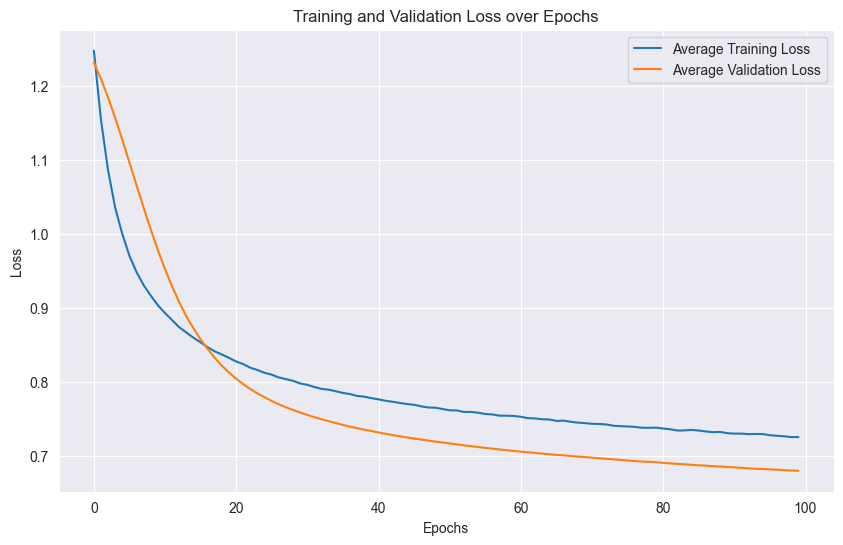

In [321]:
cross_validate_ensemble_model(autoencoder_func, train_data)

In [322]:
final_autoencoders, final_histories = train_multiple_autoencoders(3, input_dim, best_params, train_data)


Epoch 1/100
13/13 - 4s - 277ms/step - loss: 1.2277 - val_loss: 1.2239 - learning_rate: 0.0010
Epoch 2/100
13/13 - 0s - 4ms/step - loss: 1.1155 - val_loss: 1.1903 - learning_rate: 0.0010
Epoch 3/100
13/13 - 0s - 3ms/step - loss: 1.0466 - val_loss: 1.1531 - learning_rate: 0.0010
Epoch 4/100
13/13 - 0s - 3ms/step - loss: 0.9985 - val_loss: 1.1148 - learning_rate: 0.0010
Epoch 5/100
13/13 - 0s - 3ms/step - loss: 0.9638 - val_loss: 1.0764 - learning_rate: 0.0010
Epoch 6/100
13/13 - 0s - 3ms/step - loss: 0.9323 - val_loss: 1.0387 - learning_rate: 0.0010
Epoch 7/100
13/13 - 0s - 3ms/step - loss: 0.9127 - val_loss: 1.0018 - learning_rate: 0.0010
Epoch 8/100
13/13 - 0s - 3ms/step - loss: 0.8962 - val_loss: 0.9660 - learning_rate: 0.0010
Epoch 9/100
13/13 - 0s - 3ms/step - loss: 0.8783 - val_loss: 0.9339 - learning_rate: 0.0010
Epoch 10/100
13/13 - 0s - 3ms/step - loss: 0.8668 - val_loss: 0.9045 - learning_rate: 0.0010
Epoch 11/100
13/13 - 0s - 3ms/step - loss: 0.8589 - val_loss: 0.8804 - learni

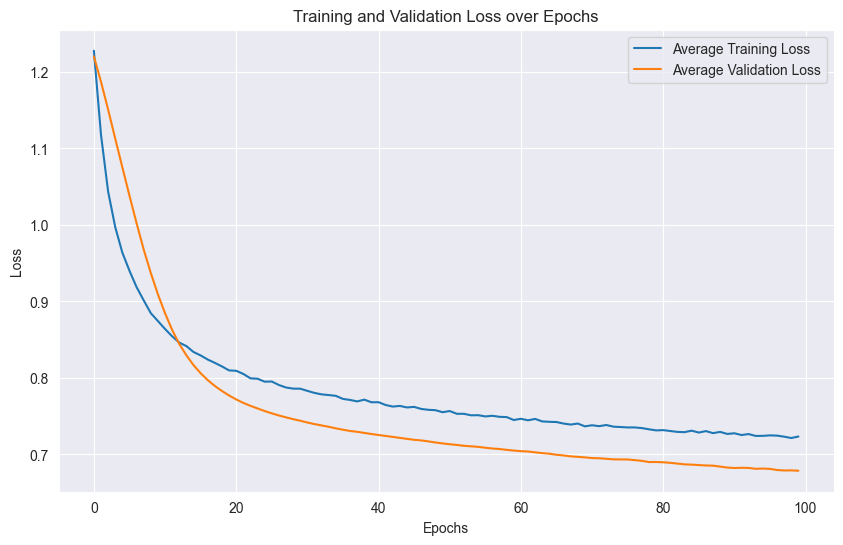

In [323]:
plot_training_history(final_histories)

In [324]:
final_combined_encoding = ensemble_encoding(final_autoencoders, test_data)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [325]:
optimal_clusters_kmeans = find_optimal_clusters(final_combined_encoding, apply_kmeans_clustering, range(2, 11))
best_labels_kmeans = apply_kmeans_clustering(final_combined_encoding, optimal_clusters_kmeans)
silhouette_avg_kmeans, davies_bouldin_kmeans = evaluate_clustering(final_combined_encoding, best_labels_kmeans)
print(f'Test Set - KMeans Silhouette Score: {silhouette_avg_kmeans}, Davies-Bouldin Score: {davies_bouldin_kmeans}')

Test Set - KMeans Silhouette Score: 0.3798470199108124, Davies-Bouldin Score: 1.0800831710940602


In [326]:
optimal_clusters_agg = find_optimal_clusters(final_combined_encoding, apply_agglomerative_clustering, range(2, 11))
best_labels_agg = apply_agglomerative_clustering(final_combined_encoding, optimal_clusters_agg)
silhouette_avg_agg, davies_bouldin_agg = evaluate_clustering(final_combined_encoding, best_labels_agg)
print(f'Test Set - Agglomerative Silhouette Score: {silhouette_avg_agg}, Davies-Bouldin Score: {davies_bouldin_agg}')

Test Set - Agglomerative Silhouette Score: 0.3945518434047699, Davies-Bouldin Score: 1.0621693528478733


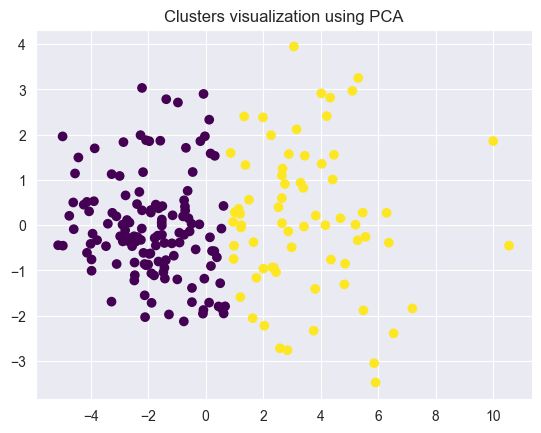

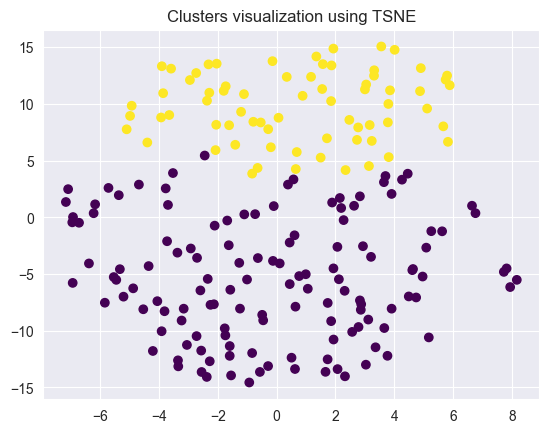

In [327]:
visualize_clusters(final_combined_encoding, best_labels_kmeans, method='pca')
visualize_clusters(final_combined_encoding, best_labels_kmeans, method='tsne')

In [350]:
expanded_involvement_columns = ['Security', 'Humanities', 'Nat. Sci', 'Health', 'AI Ethics', 'Big Data', 
                                'Robotics', 'Documents', 'Multimedia', 'NLP', 'KRR', 'Graphs', 'DL/ML', 
                                'Funding', 'Application-Oriented', 'Cybersecurity', 'Biotech', 
                                'FinTech', 'Agritech', 'MedTech', 'ClimateTech', 'EdTech', 
                                'Renewable Energy', 'Telecom', 'E-commerce']
granular_strength_map = {f'Level {i}': i for i in range(11)}

In [452]:
def load_and_preprocess_data(file_path):
    # Load the dataset
    data = pd.read_csv(file_path, index_col=0).transpose()
    data = data.replace(granular_strength_map).infer_objects(copy=False)
    
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.fillna(0, inplace=True)
    
    scaler = StandardScaler()
    data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)
    
    return data_scaled

In [453]:
file_path = 'data/new_synthetic_data.csv'
preprocessed_data = load_and_preprocess_data(file_path)

preprocessed_data.head()

/var/folders/fm/9tf79c_d1691c4jwk2qqr42m0000gn/T/ipykernel_32237/1556252184.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.replace(granular_strength_map).infer_objects(copy=False)


,Security,Humanities,Nat. Sci,Health,AI Ethics,Big Data,Robotics,Documents,Multimedia,NLP,...,Cybersecurity,Biotech,FinTech,Agritech,MedTech,ClimateTech,EdTech,Renewable Energy,Telecom,E-commerce
Team_0,-1.239841,0.341795,-0.629192,-1.573189,1.562427,-1.293851,1.568318,0.980011,0.325381,0.583654,...,-0.958007,-0.607981,0.268653,0.335345,-0.049664,0.934229,-1.251490,-1.355702,0.675313,-0.309804
Team_1,-1.239841,-0.289989,0.314596,-0.639730,-1.569945,-0.976030,-0.903908,1.628166,-0.315764,-1.326834,...,-1.606623,1.586896,-0.686274,1.626374,0.578998,-1.633215,0.645665,-1.032454,0.675313,0.948283
Team_2,0.044636,1.605363,-0.314596,-0.017425,-0.316996,-0.658208,-1.212936,-1.288533,-1.598054,0.583654,...,0.014918,0.646235,1.541888,-0.632927,1.521992,-0.670424,-0.302912,1.230282,-1.546112,-0.938848
Team_3,1.650231,-1.237664,-0.629192,-0.639730,-0.316996,-1.611673,-0.903908,0.007778,-1.277481,-0.053175,...,0.014918,1.273342,-1.004583,-0.632927,-0.678327,0.292368,-1.251490,-0.062710,0.675313,1.262805
Team_4,1.007993,-1.237664,-1.258384,-1.262036,-0.316996,-0.340387,-0.594879,0.655933,-0.956909,-0.053175,...,0.014918,-0.921535,0.268653,-1.278442,1.521992,-1.633215,0.013280,-1.678950,0.357967,0.319240


In [454]:
def add_interaction_features(data): 
    #FIXME: Refine interaction terms. This is a baseline implementation with no real insights into what industry terms should interact. Interaction will depend on the specific needs of the user.
    
    # Create a new DataFrame to store the aggregate features for each team
    aggregate_features = pd.DataFrame(index=data.index)
    
    aggregate_features['AI_Health_Interaction'] = data['AI Ethics'] * data['Health']
    aggregate_features['AI_BigData_Interaction'] = data['AI Ethics'] * data['Big Data']
    aggregate_features['Health_NatSci_Interaction'] = data['Health'] * data['Nat. Sci']
    aggregate_features['Robotics_Documents_Interaction'] = data['Robotics'] * data['Documents']
    aggregate_features['NLP_KRR_Interaction'] = data['NLP'] * data['KRR']
    aggregate_features['Graphs_DLML_Interaction'] = data['Graphs'] * data['DL/ML']

    # Sum interaction features
    aggregate_features['AI_BigData_Sum'] = data['AI Ethics'] + data['Big Data']
    aggregate_features['Health_NatSci_Sum'] = data['Health'] + data['Nat. Sci']

    # Difference interaction features
    aggregate_features['AI_BigData_Diff'] = data['AI Ethics'] - data['Big Data']
    aggregate_features['Health_NatSci_Diff'] = data['Health'] - data['Nat. Sci']


    return aggregate_features

In [455]:
# Add interaction features to the preprocessed data
interaction_features = add_interaction_features(preprocessed_data)

# Combine the interaction features with the original preprocessed data
combined_data = pd.concat([preprocessed_data, interaction_features], axis=1)

combined_data.head()

,Security,Humanities,Nat. Sci,Health,AI Ethics,Big Data,Robotics,Documents,Multimedia,NLP,...,AI_Health_Interaction,AI_BigData_Interaction,Health_NatSci_Interaction,Robotics_Documents_Interaction,NLP_KRR_Interaction,Graphs_DLML_Interaction,AI_BigData_Sum,Health_NatSci_Sum,AI_BigData_Diff,Health_NatSci_Diff
Team_0,-1.239841,0.341795,-0.629192,-1.573189,1.562427,-1.293851,1.568318,0.980011,0.325381,0.583654,...,-2.457993,-2.021549,0.989838,1.536969,0.951257,-1.972398,0.268576,-2.202381,2.856279,-0.943996
Team_1,-1.239841,-0.289989,0.314596,-0.639730,-1.569945,-0.976030,-0.903908,1.628166,-0.315764,-1.326834,...,1.004341,1.532313,-0.201257,-1.471712,-2.162514,-1.172438,-2.545975,-0.325134,-0.593915,-0.954326
Team_2,0.044636,1.605363,-0.314596,-0.017425,-0.316996,-0.658208,-1.212936,-1.288533,-1.598054,0.583654,...,0.005524,0.208649,0.005482,1.562907,0.761423,-1.176180,-0.975204,-0.332021,0.341212,0.297172
Team_3,1.650231,-1.237664,-0.629192,-0.639730,-0.316996,-1.611673,-0.903908,0.007778,-1.277481,-0.053175,...,0.202792,0.510894,0.402513,-0.007030,-0.000190,0.951498,-1.928669,-1.268922,1.294677,-0.010538
Team_4,1.007993,-1.237664,-1.258384,-1.262036,-0.316996,-0.340387,-0.594879,0.655933,-0.956909,-0.053175,...,0.400060,0.107901,1.588126,-0.390201,-0.000190,1.273628,-0.657383,-2.520420,0.023391,-0.003651


In [456]:
train_data, test_data = train_test_split(combined_data, test_size=0.2, random_state=42)
input_dim = train_data.shape[1]

# Additional validation split from training data
train_data_split, val_data_split = train_test_split(train_data, test_size=0.2, random_state=42)


In [448]:
param_grid = {
    'layer_sizes': [[128, 64], [64, 32], [32, 16]],
    'encoding_dim': [8, 16, 32],
    'dropout_rate': [0.2, 0.3],
    'batch_size': [32, 64],
    'epochs': [50, 100]
}

In [457]:
from sklearn.model_selection import ParameterGrid

# Create a parameter grid
param_combinations = list(ParameterGrid(param_grid))

best_score = -1
best_params = None

for params in param_combinations:
    print(f"Testing with params: {params}")
    
    # Create and train the autoencoder
    autoencoder = create_autoencoder(input_dim, params['encoding_dim'], params['layer_sizes'], params['dropout_rate'])
    
    # Train the autoencoder
    history = train_autoencoder(autoencoder, train_data_split, val_data_split, epochs=params['epochs'], batch_size=params['batch_size'])
    
    # Get encoded data
    encoded_data = get_encoded_data(autoencoder, test_data)
    
    # Find optimal clusters
    optimal_clusters = find_optimal_clusters(encoded_data, apply_kmeans_clustering, range(2, 11))
    best_labels_kmeans = apply_kmeans_clustering(encoded_data, optimal_clusters)
    
    # Evaluate clustering
    silhouette_avg_kmeans, davies_bouldin_kmeans = evaluate_clustering(encoded_data, best_labels_kmeans)
    
    if silhouette_avg_kmeans > best_score:
        best_score = silhouette_avg_kmeans
        best_params = params
        print(f"New best score: {best_score} with params: {best_params}")

print(f"Best parameters found: {best_params} with silhouette score: {best_score}")


Testing with params: {'batch_size': 32, 'dropout_rate': 0.2, 'encoding_dim': 8, 'epochs': 50, 'layer_sizes': [128, 64]}
Epoch 1/50
20/20 - 3s - 153ms/step - loss: 1.2978 - val_loss: 1.3708 - learning_rate: 0.0010
Epoch 2/50
20/20 - 0s - 2ms/step - loss: 1.1680 - val_loss: 1.3206 - learning_rate: 0.0010
Epoch 3/50
20/20 - 0s - 2ms/step - loss: 1.0980 - val_loss: 1.2647 - learning_rate: 0.0010
Epoch 4/50
20/20 - 0s - 2ms/step - loss: 1.0568 - val_loss: 1.2057 - learning_rate: 0.0010
Epoch 5/50
20/20 - 0s - 2ms/step - loss: 1.0287 - val_loss: 1.1574 - learning_rate: 0.0010
Epoch 6/50
20/20 - 0s - 2ms/step - loss: 1.0074 - val_loss: 1.1164 - learning_rate: 0.0010
Epoch 7/50
20/20 - 0s - 2ms/step - loss: 0.9955 - val_loss: 1.0834 - learning_rate: 0.0010
Epoch 8/50
20/20 - 0s - 2ms/step - loss: 0.9818 - val_loss: 1.0585 - learning_rate: 0.0010
Epoch 9/50
20/20 - 0s - 2ms/step - loss: 0.9752 - val_loss: 1.0411 - learning_rate: 0.0010
Epoch 10/50
20/20 - 0s - 4ms/step - loss: 0.9695 - val_loss

In [460]:
final_autoencoders, final_histories = train_multiple_autoencoders(3, input_dim, best_params, train_data)

Epoch 1/50
13/13 - 2s - 120ms/step - loss: 1.3941 - val_loss: 1.3633 - learning_rate: 0.0010
Epoch 2/50
13/13 - 0s - 3ms/step - loss: 1.3572 - val_loss: 1.3468 - learning_rate: 0.0010
Epoch 3/50
13/13 - 0s - 3ms/step - loss: 1.3284 - val_loss: 1.3283 - learning_rate: 0.0010
Epoch 4/50
13/13 - 0s - 3ms/step - loss: 1.3076 - val_loss: 1.3084 - learning_rate: 0.0010
Epoch 5/50
13/13 - 0s - 3ms/step - loss: 1.2755 - val_loss: 1.2861 - learning_rate: 0.0010
Epoch 6/50
13/13 - 0s - 3ms/step - loss: 1.2525 - val_loss: 1.2629 - learning_rate: 0.0010
Epoch 7/50
13/13 - 0s - 3ms/step - loss: 1.2294 - val_loss: 1.2391 - learning_rate: 0.0010
Epoch 8/50
13/13 - 0s - 2ms/step - loss: 1.2086 - val_loss: 1.2158 - learning_rate: 0.0010
Epoch 9/50
13/13 - 0s - 3ms/step - loss: 1.1934 - val_loss: 1.1927 - learning_rate: 0.0010
Epoch 10/50
13/13 - 0s - 2ms/step - loss: 1.1731 - val_loss: 1.1713 - learning_rate: 0.0010
Epoch 11/50
13/13 - 0s - 2ms/step - loss: 1.1557 - val_loss: 1.1510 - learning_rate: 0.

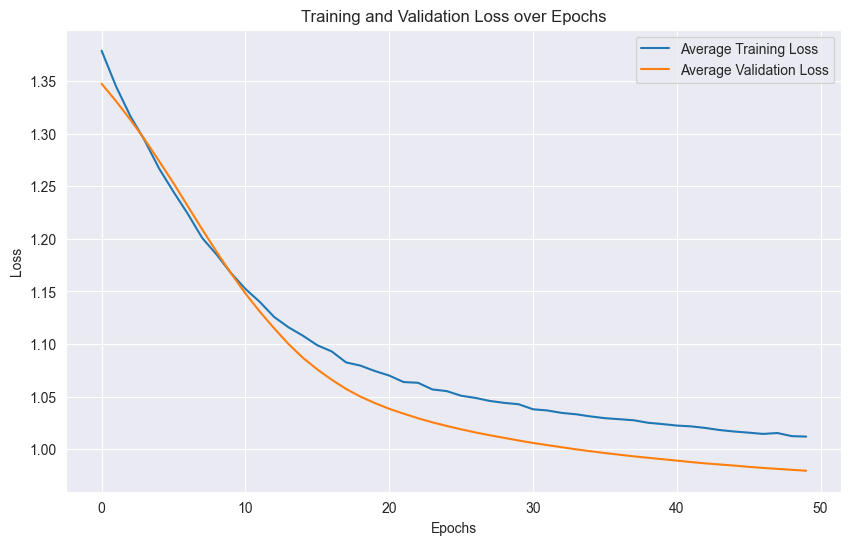

In [461]:
plot_training_history(final_histories)

In [462]:
final_combined_encoding = ensemble_encoding(final_autoencoders, test_data)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [463]:
def compute_cluster_statistics(data, labels):

    data_with_labels = data.copy()
    data_with_labels['Cluster'] = labels
    
    cluster_stats = data_with_labels.groupby('Cluster').mean()
    
    return cluster_stats

In [464]:
def plot_cluster_statistics(cluster_stats, title='Cluster Statistics'):
    plt.figure(figsize=(20, 12))  # Increase the figure size for better readability
    
    # Set vmin and vmax for better color scaling
    vmin = cluster_stats.min().min()
    vmax = cluster_stats.max().max()
    
    sns.heatmap(cluster_stats, annot=True, fmt='.2f', cmap='viridis', vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to fit everything in the figure area
    plt.show()

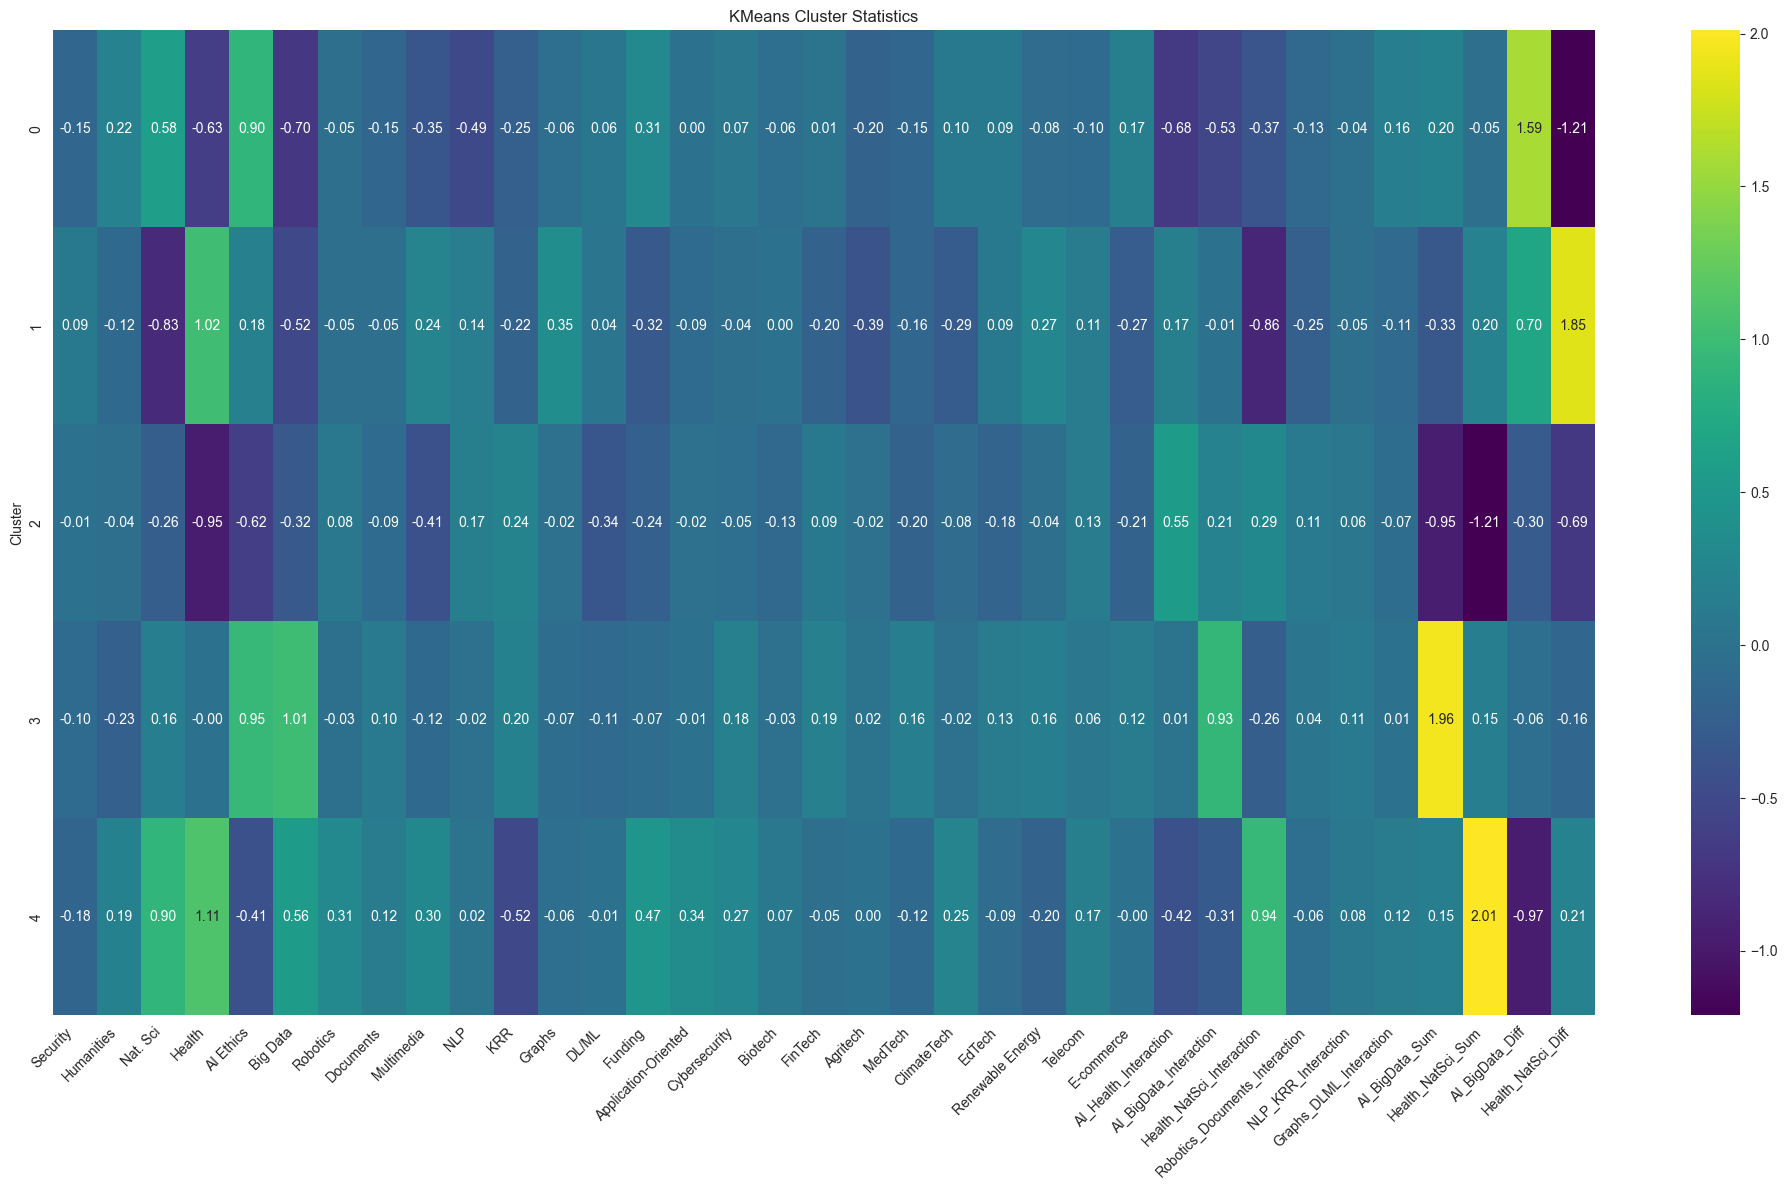

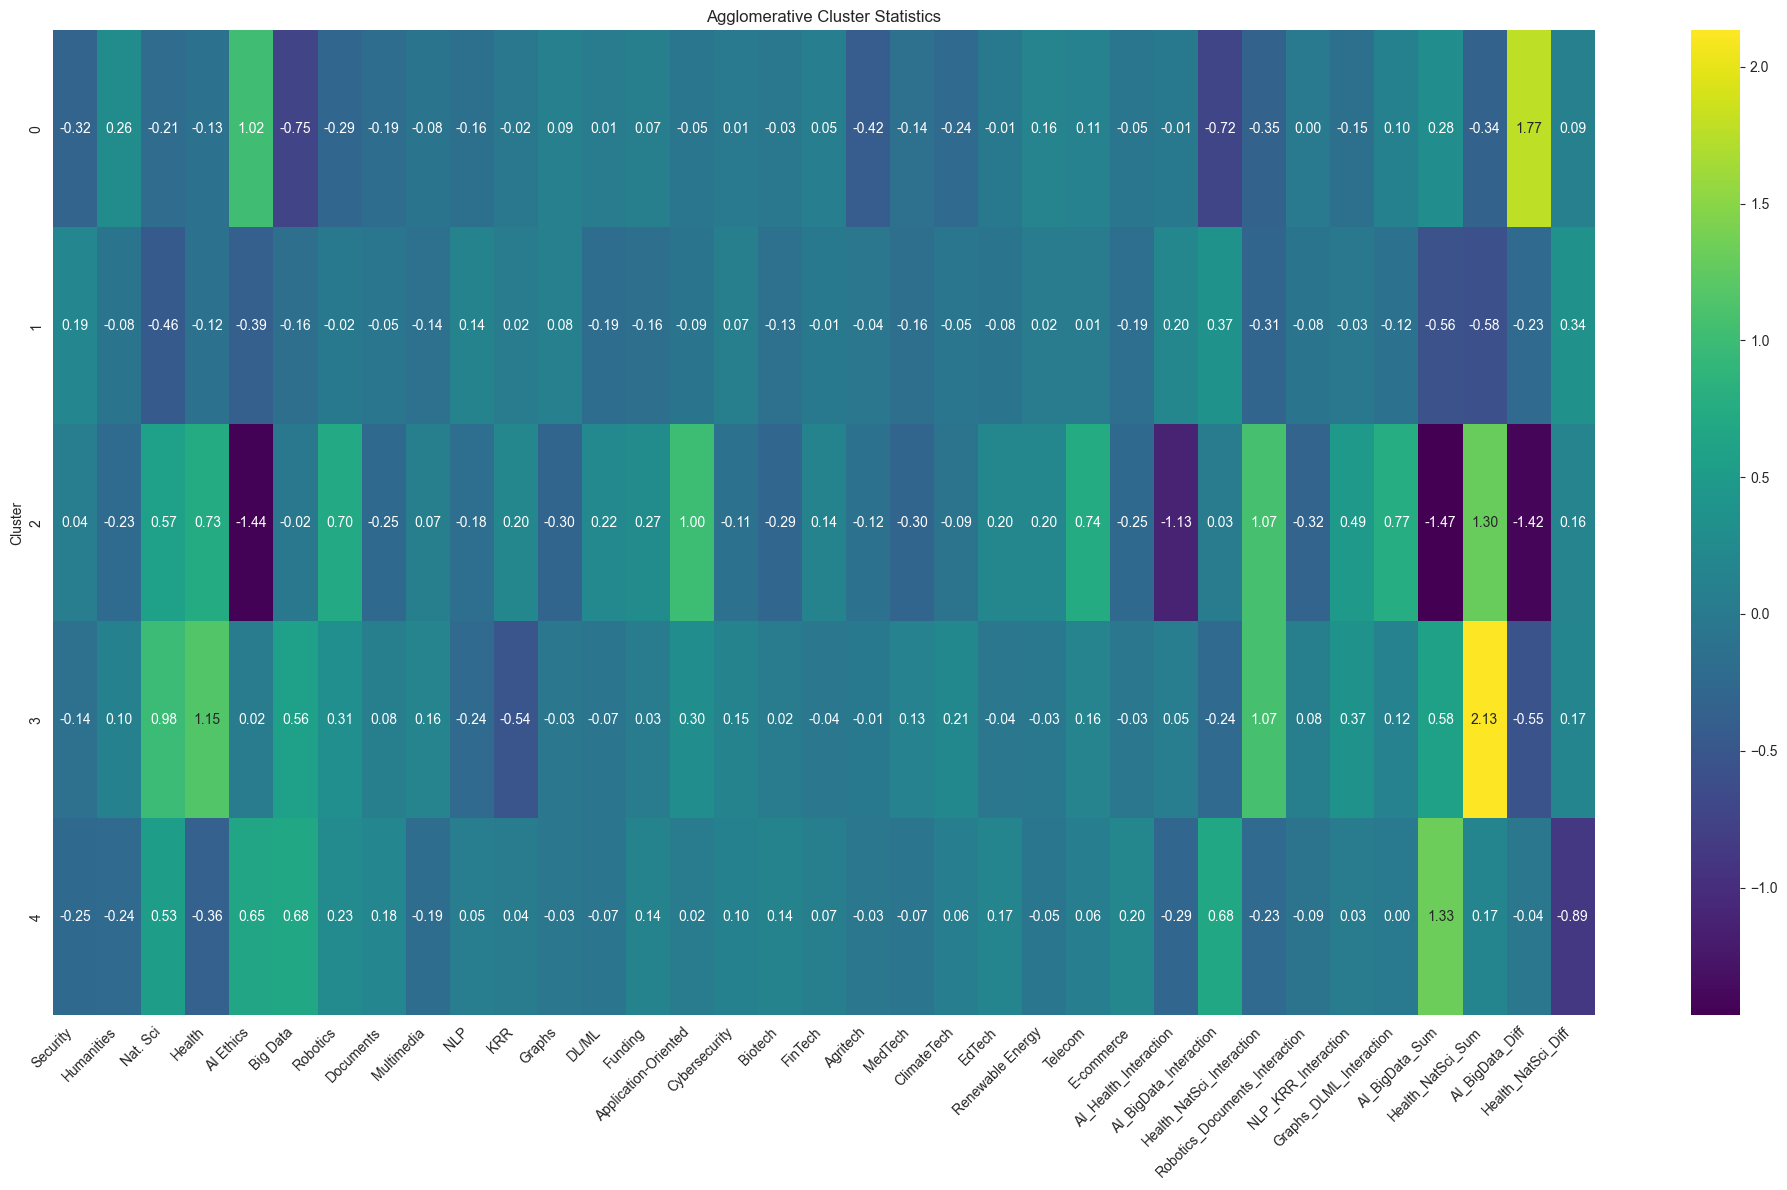

In [465]:
cluster_stats_kmeans = compute_cluster_statistics(test_data, best_labels_kmeans)
cluster_stats_agg = compute_cluster_statistics(test_data, best_labels_agg)

# Plot the cluster statistics
plot_cluster_statistics(cluster_stats_kmeans, title='KMeans Cluster Statistics')
plot_cluster_statistics(cluster_stats_agg, title='Agglomerative Cluster Statistics')

In [466]:
optimal_clusters_kmeans = find_optimal_clusters(final_combined_encoding, apply_kmeans_clustering, range(2, 11))
best_labels_kmeans = apply_kmeans_clustering(final_combined_encoding, optimal_clusters_kmeans)
silhouette_avg_kmeans, davies_bouldin_kmeans = evaluate_clustering(final_combined_encoding, best_labels_kmeans)
print(f'Test Set - KMeans Silhouette Score: {silhouette_avg_kmeans}, Davies-Bouldin Score: {davies_bouldin_kmeans}')


Silhouette Scores: [0.26113376, 0.215377, 0.19331093, 0.20015687, 0.18656914, 0.21893278, 0.193717, 0.19722667, 0.20267364]
Davies-Bouldin Scores: [1.5475144394758347, 1.5002067154432532, 1.4863352620421435, 1.4428407154641891, 1.4433837776776095, 1.2917212796663315, 1.4124735759181286, 1.3693130971894434, 1.308076179590039]
Inertia Scores: [280.9075927734375, 231.8509521484375, 207.46640014648438, 181.24734497070312, 169.2025146484375, 143.07566833496094, 135.90992736816406, 128.10614013671875, 118.34391784667969]
Optimal number of clusters determined: 7
Test Set - KMeans Silhouette Score: 0.21893277764320374, Davies-Bouldin Score: 1.2917212796663315


In [467]:
optimal_clusters_agg = find_optimal_clusters(final_combined_encoding, apply_agglomerative_clustering, range(2, 11))
best_labels_agg = apply_agglomerative_clustering(final_combined_encoding, optimal_clusters_agg)
silhouette_avg_agg, davies_bouldin_agg = evaluate_clustering(final_combined_encoding, best_labels_agg)
print(f'Test Set - Agglomerative Silhouette Score: {silhouette_avg_agg}, Davies-Bouldin Score: {davies_bouldin_agg}')

Silhouette Scores: [0.24330387, 0.22561759, 0.16576664, 0.1805169, 0.19130522, 0.21309295, 0.1946539, 0.19994274, 0.19440746]
Davies-Bouldin Scores: [1.6356619022108152, 1.3531805989870618, 1.5671282400758146, 1.4802492160409664, 1.3788553866012638, 1.2626672660768197, 1.2978429851494804, 1.2807429338150385, 1.273399987706215]
Inertia Scores: [280.9075927734375, 231.8509521484375, 207.46640014648438, 181.24734497070312, 169.2025146484375, 143.07566833496094, 135.90992736816406, 128.10614013671875, 118.34391784667969]
Optimal number of clusters determined: 7
Test Set - Agglomerative Silhouette Score: 0.21309295296669006, Davies-Bouldin Score: 1.2626672660768197


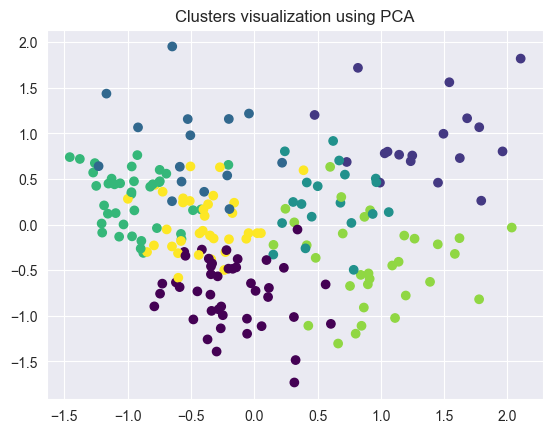

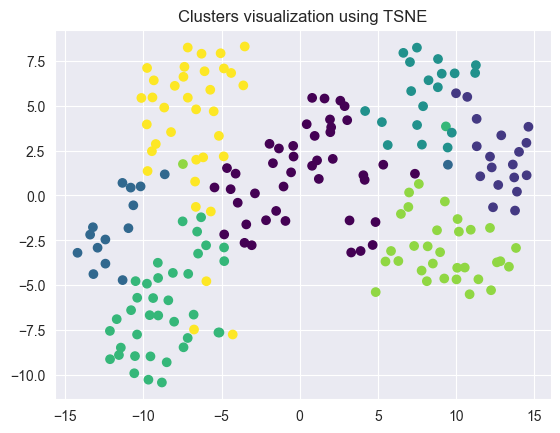

In [468]:
visualize_clusters(final_combined_encoding, best_labels_kmeans, method='pca')
visualize_clusters(final_combined_encoding, best_labels_kmeans, method='tsne')

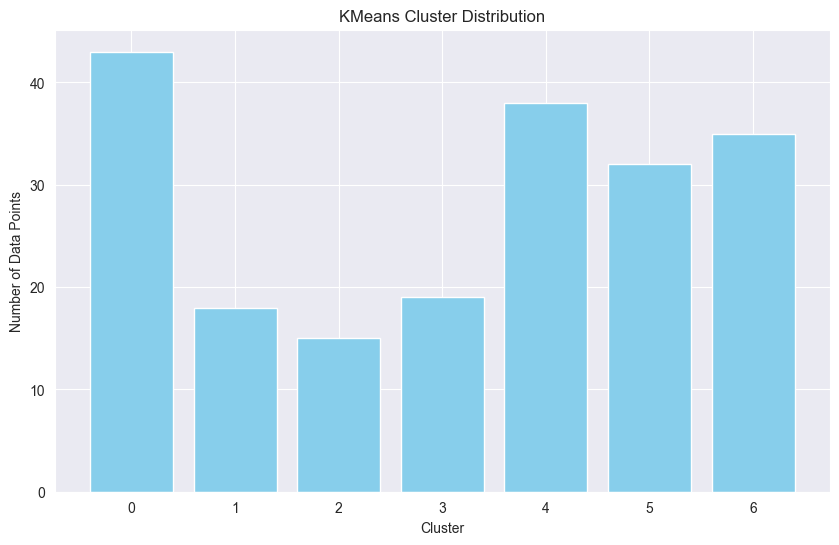

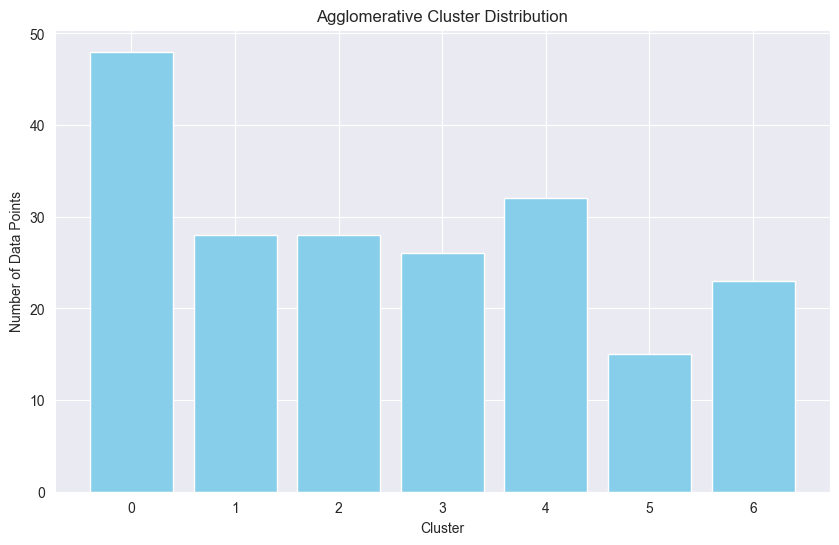

In [469]:
def plot_class_distribution(labels, title='Cluster Distribution'):
    unique, counts = np.unique(labels, return_counts=True)
    distribution = dict(zip(unique, counts))
    
    plt.figure(figsize=(10, 6))
    plt.bar(distribution.keys(), distribution.values(), color='skyblue')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Data Points')
    plt.title(title)
    plt.show()

# Assuming best_labels_kmeans contains the labels for the clusters
plot_class_distribution(best_labels_kmeans, title='KMeans Cluster Distribution')

# Assuming best_labels_agg contains the labels for the clusters
plot_class_distribution(best_labels_agg, title='Agglomerative Cluster Distribution')
